# 05a: Data Preparation for CNN-LSTM

This notebook provides a comprehensive, stepwise workflow for preparing ICU time series and static data for deep learning models.

**Goals:**
- Prepare dynamic (time series), static, and outcome data for CNN-LSTM modeling
- Select clinically relevant features and apply appropriate transformations
- Address missingness, scaling, and class imbalance
- Construct patient-level sequences and align static features
- Save processed datasets for downstream modeling and analysis


## Workflow Overview

This notebook prepares ICU time series and static data for CNN-LSTM modeling. The workflow includes:

1. **Data Loading and Audit:** Load cleaned data, preview, and check types.
2. **Feature Selection:** Select EDA-driven dynamic and static features.
3. **Log Transformation:** Apply log1p to skewed static features.
4. **Sequence Construction:** Group by patient, extract sequences and static features.
5. **Padding and Scaling:** Pad sequences and scale features.
6. **Train/Val/Test Split:** Patient-index-based splitting for alignment.
7. **Class Imbalance Handling:** Apply SMOTE to training set.
8. **Save Processed Data:** Store arrays for modeling.





### 1: Import Libraries and Set Configuration
Import all required libraries for data manipulation, visualization, and machine learning. Set random seeds and plotting styles for reproducibility and consistent visuals.

In [17]:
# Imports and Configuration
import pandas as pd
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 2: Load and Audit Data
Load the cleaned ICU time series dataset and missingness mask. Preview the data and check types to ensure correct loading. Summarize the shape and schema for transparency.

In [18]:
# Load cleaned data
data = pd.read_csv('../data/processed/timeseries_cleaned_all_features.csv')
mask = pd.read_csv('../data/processed/timeseries_missingness_mask.csv')
print('Data shape:', data.shape)

# Preview
display(data.head())
print(data.dtypes)

Data shape: (295354, 48)


,RecordID,Minutes,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,MAP,MechVent,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,pH,Age,Gender,Height,ICUType,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival,Weight
0,132539,7,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,73.0,4.4,0.0,0.0,0.0,1.5,65.0,92.33,147.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.1,0.0,0.0,900.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
1,132539,37,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,77.0,4.4,0.0,0.0,0.0,1.5,58.0,91.00,157.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,60.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
2,132539,97,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,60.0,4.4,0.0,0.0,0.0,1.5,62.0,87.00,137.0,137.0,0.0,0.0,221.0,18.0,0.0,0.0,35.6,0.0,0.0,30.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
3,132539,157,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,62.0,4.4,0.0,0.0,0.0,1.5,52.0,75.67,123.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,170.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6
4,132539,188,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.8,0.0,0.0,15.0,205.0,26.0,33.7,62.0,4.4,0.0,0.0,0.0,1.5,52.0,75.67,123.0,137.0,0.0,0.0,221.0,19.0,0.0,0.0,35.6,0.0,0.0,170.0,11.2,0.0,54.0,0.0,170.2,4.0,0.0,5.0,6.0,1.0,70.0,78.6


RecordID               int64
Minutes                int64
ALP                  float64
ALT                  float64
AST                  float64
Albumin              float64
BUN                  float64
Bilirubin            float64
Cholesterol          float64
Creatinine           float64
DiasABP              float64
FiO2                 float64
GCS                  float64
Glucose              float64
HCO3                 float64
HCT                  float64
HR                   float64
K                    float64
Lactate              float64
MAP                  float64
MechVent             float64
Mg                   float64
NIDiasABP            float64
NIMAP                float64
NISysABP             float64
Na                   float64
PaCO2                float64
PaO2                 float64
Platelets            float64
RespRate             float64
SaO2                 float64
SysABP               float64
Temp                 float64
TroponinI            float64
TroponinT     

### 3: Feature Selection and Engineering
Select dynamic (time series) and static features based on EDA and clinical relevance. Engineer derived features such as Shock Index, PaO2/FiO2 ratio, Pulse Pressure, and MAP to HR ratio to enhance clinical interpretability.

In [19]:
# Dynamic (time series) features
time_series_features = [
    'HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp',
    # Clinically meaningful combinations of vitals
    'Shock Index',          # HR / SysABP
    'PaO2/FiO2 ratio',      # PaO₂ / FiO₂
    'Pulse Pressure',       # SysABP − DiasABP
    'MAP to HR ratio'       # MAP / HR
]

# Static features
static_features = [
    'Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA'
]

target_col = 'In-hospital_death'

# Derived features
data['Shock Index'] = np.where(
    data['SysABP'] > 0,
    data['HR'] / data['SysABP'],
    np.nan
)

data['PaO2/FiO2 ratio'] = np.where(
    data['FiO2'] > 0,
    data['PaO2'] / data['FiO2'],
    np.nan
)

data['Pulse Pressure'] = np.where(
    (data['SysABP'].notna()) & (data['DiasABP'].notna()),
    data['SysABP'] - data['DiasABP'],
    np.nan
)

data['MAP to HR ratio'] = np.where(
    data['HR'] > 0,
    data['MAP'] / data['HR'],
    np.nan
)

print("Dynamic Features:", time_series_features)
print("Static Features:", static_features)
print("Target:", target_col)

Dynamic Features: ['HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent', 'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2', 'Creatinine', 'BUN', 'Urine', 'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH', 'GCS', 'Temp', 'Shock Index', 'PaO2/FiO2 ratio', 'Pulse Pressure', 'MAP to HR ratio']
Static Features: ['Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA']
Target: In-hospital_death


###  4: Time Series Data Visualization
Visualize time series patterns for selected patients and features. This step helps validate data quality, identify temporal trends, and assess missingness visually.

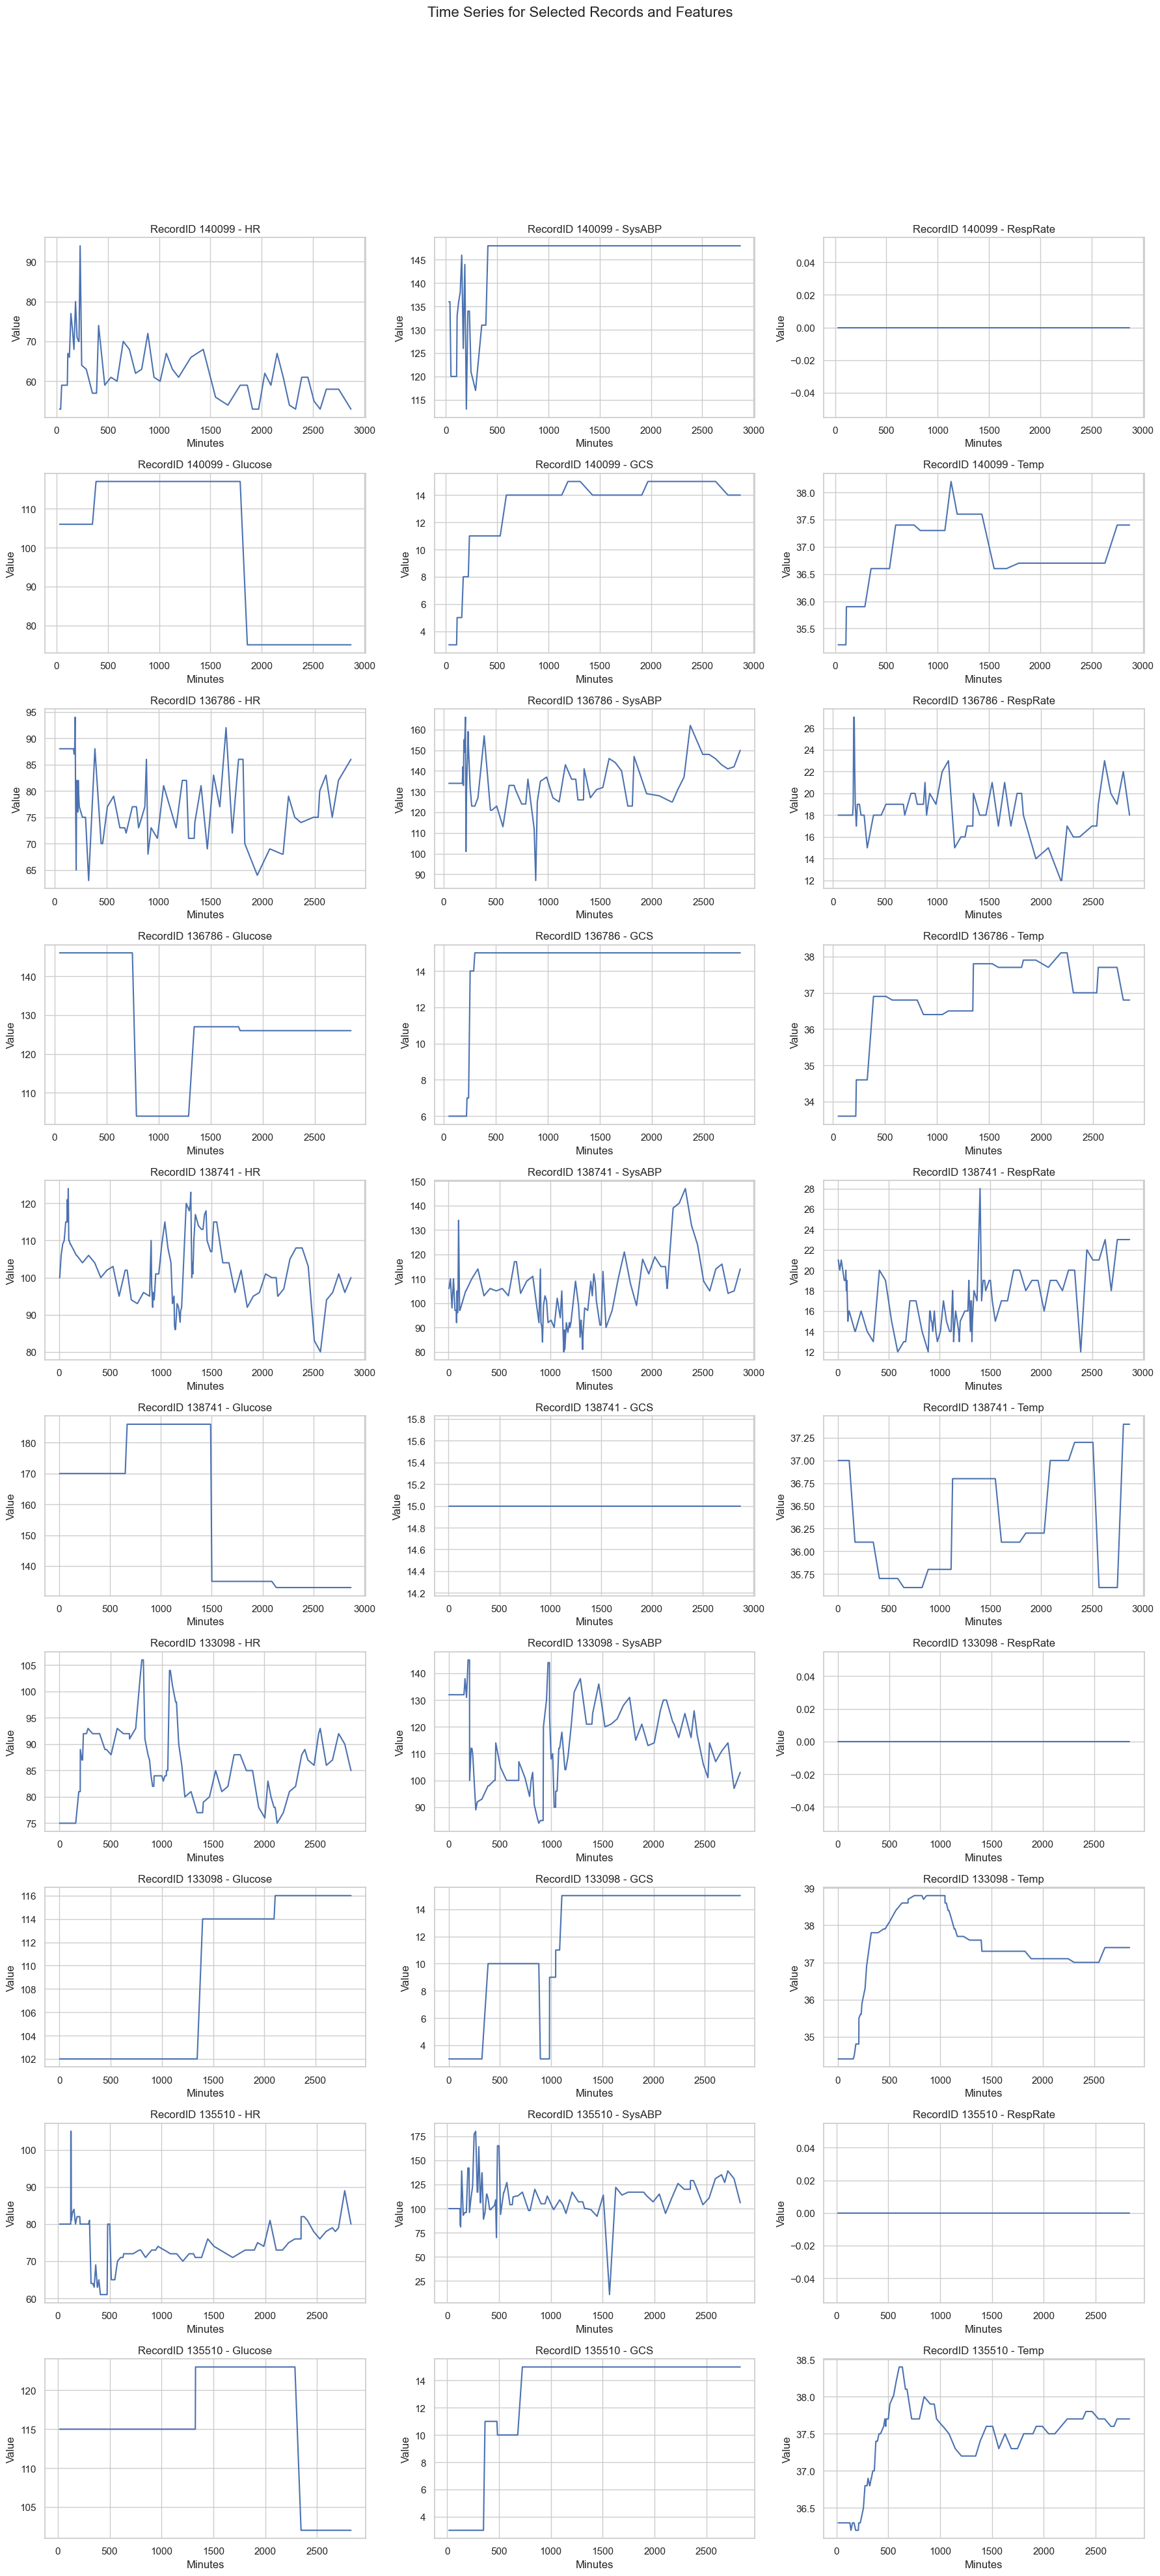

In [20]:
# Visualize time series for selected patient records
# Get a list of unique RecordIDs
record_ids = data['RecordID'].unique()

# Select a few random RecordIDs to visualize
num_records_to_visualize = 5 # You can change this number
selected_record_ids = random.sample(list(record_ids), num_records_to_visualize)

# Select a subset of dynamic features to visualize
features_to_plot = ['HR', 'SysABP', 'RespRate', 'Glucose', 'GCS', 'Temp']

grouped = data.groupby('RecordID')

n_plots = num_records_to_visualize * len(features_to_plot)
n_cols = min(len(features_to_plot), 3)
n_rows = math.ceil(n_plots / n_cols)

plt.figure(figsize=(n_cols * 6, n_rows * 4))
plt.suptitle('Time Series for Selected Records and Features', y=1.02, fontsize=16)

plot_index = 1
for record_id in selected_record_ids:
    group = grouped.get_group(record_id)

    for col in features_to_plot:
        if col in group.columns:
            plt.subplot(n_rows, n_cols, plot_index)
            plt.plot(group['Minutes'], group[col])
            plt.title(f'RecordID {record_id} - {col}')
            plt.xlabel('Minutes')
            plt.ylabel('Value')
            plot_index += 1
        else:
            print(f"Warning: Feature '{col}' not found for RecordID {record_id}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 5. Static Feature and Target Extraction
Extract static features and target variable for each patient. This ensures proper alignment of static and outcome data for downstream modeling and analysis.

In [21]:
# Extract static features for each patient (one row per patient)
patient_static_data = data.groupby('RecordID')[static_features].first().reset_index()

# Extract target variable
patient_outcomes = data.groupby('RecordID')[target_col].first().reset_index()

# Convert to arrays
X_static = patient_static_data[static_features].values
y = patient_outcomes[target_col].values

print("Shape of static features:", X_static.shape)
print("Shape of target variable:", y.shape)
print("Class distribution:", np.unique(y, return_counts=True))

Shape of static features: (3997, 7)
Shape of target variable: (3997,)
Class distribution: (array([0., 1.]), array([3443,  554], dtype=int64))


### 6: Data Preparation Class Definition
This section defines the `ICUDataPreparer` class, which encapsulates the entire data preparation pipeline for CNN-LSTM modeling. The class is designed to be modular and reproducible, handling all preprocessing steps in a systematic way.

**Key Steps Performed:**
- **Initialization:** Accepts file paths, feature lists, and target column as input parameters.
- **Data Loading:** Reads the cleaned time series data and missingness mask from disk.
- **Feature Engineering:** Adds derived features (Shock Index, PaO2/FiO2 ratio, Pulse Pressure, MAP to HR ratio) to enhance clinical interpretability.
- **Static Feature Extraction:** Aggregates static features for each patient and aligns them with the target variable.
- **Sequence Construction:** Groups time series data by patient and constructs hourly sequences up to a specified time window.
- **Padding:** Pads sequences to a uniform length for model compatibility.
- **Train/Val/Test Split:** Splits data into training, validation, and test sets using stratified sampling to preserve class balance.
- **Cleaning:** Handles missing and infinite values by replacing them with appropriate defaults.
- **Scaling:** Applies standard scaling to both time series and static features, fitting only on the training set and transforming validation/test sets.
- **Log Transformation:** Applies log1p transformation to highly skewed static features to normalize distributions.
- **Imputation:** Imputes missing values in time series features using mean imputation.
- **Class Imbalance Handling:** Uses SMOTE to oversample the minority class in the training set, ensuring balanced data for model training.
- **Synthetic Static Feature Handling:** For synthetic samples generated by SMOTE, static features are sampled from the minority class to maintain consistency.


In [22]:
class ICUDataPreparer:
    def __init__(self, data_path, mask_path, time_series_features, static_features, target_col):
        self.data_path = data_path
        self.mask_path = mask_path
        self.time_series_features = time_series_features
        self.static_features = static_features
        self.target_col = target_col
        self.data = None
        self.X_static = None
        self.y = None

    def load_and_prepare_data(self):
        """Loads data, adds derived features, extracts static features and target."""
        self.data = pd.read_csv(self.data_path)


        # Add derived features
        self.data['Shock Index'] = np.where(
            self.data['SysABP'] > 0,
            self.data['HR'] / self.data['SysABP'],
            np.nan
        )
        self.data['PaO2/FiO2 ratio'] = np.where(
            self.data['FiO2'] > 0,
            self.data['PaO2'] / self.data['FiO2'],
            np.nan
        )
        self.data['Pulse Pressure'] = np.where(
            (self.data['SysABP'].notna()) & (self.data['DiasABP'].notna()),
            self.data['SysABP'] - self.data['DiasABP'],
            np.nan
        )
        self.data['MAP to HR ratio'] = np.where(
            self.data['HR'] > 0,
            self.data['MAP'] / self.data['HR'],
            np.nan
        )

        # Extract static features for each patient (one row per patient)
        patient_static_data = self.data.groupby('RecordID')[self.static_features].first().reset_index()
        self.X_static = patient_static_data[self.static_features].values

        # Extract target variable
        patient_outcomes = self.data.groupby('RecordID')[self.target_col].first().reset_index()
        self.y = patient_outcomes[self.target_col].values

        print('Data shape:', self.data.shape)
        print("Shape of static features:", self.X_static.shape)
        print("Shape of target variable:", self.y.shape)
        print("Class distribution:", np.unique(self.y, return_counts=True))


    def construct_hourly_sequences(self, max_time_minutes):
        """Constructs hourly sequences up to max_time_minutes."""
        if self.data is None:
            raise ValueError("Data not loaded. Call load_and_prepare_data() first.")

        hourly_sequences = []
        hour_window_size = 60  # 1 hour in minutes
        hourly_window_boundaries = np.arange(0, max_time_minutes + hour_window_size, hour_window_size)

        for record_id, group in self.data.groupby('RecordID'):
            patient_sequence = []
            for i in range(len(hourly_window_boundaries) - 1):
                start_time = hourly_window_boundaries[i]
                end_time = hourly_window_boundaries[i+1]
                window_data = group[(group['Minutes'] >= start_time) & (group['Minutes'] < end_time)]

                if not window_data.empty:
                    hourly_features = window_data[self.time_series_features].iloc[0].values
                else:
                    hourly_features = np.full(len(self.time_series_features), np.nan)
                patient_sequence.append(hourly_features)
            hourly_sequences.append(patient_sequence)

        return np.array(hourly_sequences, dtype=np.float32)

    def process_data_for_resolution(self, resolution_hours):
        """Processes data for a given temporal resolution."""
        if self.data is None:
            raise ValueError("Data not loaded. Call load_and_prepare_data() first.")

        max_time_minutes = resolution_hours * 60
        X_hourly_seq = self.construct_hourly_sequences(max_time_minutes)

        # Pad sequences
        max_seq_len = resolution_hours
        X_seq_padded = pad_sequences(X_hourly_seq, maxlen=max_seq_len, dtype='float32', padding='post', value=0.0)
        n_features = X_hourly_seq.shape[2]

        # Get patient indices
        n_patients = X_seq_padded.shape[0]
        indices = np.arange(n_patients)

        # Stratified split
        train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=self.y, random_state=42)
        train_idx, val_idx  = train_test_split(train_idx, test_size=0.2, stratify=self.y[train_idx], random_state=42)

        # Split datasets
        X_train, X_val, X_test = X_seq_padded[train_idx], X_seq_padded[val_idx], X_seq_padded[test_idx]
        static_train, static_val, static_test = self.X_static[train_idx], self.X_static[val_idx], self.X_static[test_idx]
        y_train, y_val, y_test = self.y[train_idx], self.y[val_idx], self.y[test_idx]

        # Clean NaNs/Infs before processing
        def clean_array(arr):
            return np.nan_to_num(arr, nan=0.0, posinf=1e6, neginf=-1e6)

        X_train = clean_array(X_train)
        X_val   = clean_array(X_val)
        X_test  = clean_array(X_test)

        static_train_cleaned = clean_array(static_train)
        static_val_cleaned   = clean_array(static_val)
        static_test_cleaned  = clean_array(static_test)


        # Scale time series features (fit only on train, transform val/test)
        seq_scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, n_features)
        X_train_scaled = seq_scaler.fit_transform(X_train_reshaped).reshape(-1, max_seq_len, n_features)
        X_val_reshaped = X_val.reshape(-1, n_features)
        X_val_scaled = seq_scaler.transform(X_val_reshaped).reshape(-1, max_seq_len, n_features)
        X_test_reshaped = X_test.reshape(-1, n_features)
        X_test_scaled = seq_scaler.transform(X_test_reshaped).reshape(-1, max_seq_len, n_features)

        # Scale static features
        static_scaler = StandardScaler()
        static_train_scaled = static_scaler.fit_transform(static_train_cleaned)
        static_val_scaled   = static_scaler.transform(static_val_cleaned)
        static_test_scaled  = static_scaler.transform(static_test_cleaned)

        # Log transformation of highly skewed static features (fit only on train, apply to val/test)
        static_features_for_skew_check = [col for col in self.static_features if col not in ['Gender', 'ICUType']]
        skewness = pd.DataFrame(static_train_cleaned, columns=self.static_features)[static_features_for_skew_check].skew().sort_values(ascending=False)
        skewness_threshold = 1.0
        highly_skewed_features = skewness[abs(skewness) > skewness_threshold].index.tolist()
        print(f"Highly skewed static features (absolute skewness > {skewness_threshold}): {highly_skewed_features}")

        for col in highly_skewed_features:
            idx = self.static_features.index(col)
            if (static_train_scaled[:, idx] < -1e-9).any():
                 print(f"Warning: Column '{col}' in training set contains negative values after scaling. log1p may not be appropriate.")
                 continue
            static_train_scaled[:, idx] = np.log1p(static_train_scaled[:, idx])
            static_val_scaled[:, idx] = np.log1p(np.maximum(static_val_scaled[:, idx], 0))
            static_test_scaled[:, idx] = np.log1p(np.maximum(static_test_scaled[:, idx], 0))
            print(f"Applied log1p to '{col}' in train/val/test sets")


        # Impute dynamic features (fit on train, apply to val/test)
        X_train_flat = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed_flat = imputer.fit_transform(X_train_flat)

        X_val_flat  = X_val_scaled.reshape(X_val_scaled.shape[0], -1)
        X_test_flat = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
        X_val_imputed_flat  = imputer.transform(X_val_flat)
        X_test_imputed_flat = imputer.transform(X_test_flat)

        # Reshape back to original sequence format
        X_train_imputed = X_train_imputed_flat.reshape(-1, X_train_scaled.shape[1], X_train_scaled.shape[2])
        X_val_imputed   = X_val_imputed_flat.reshape(-1, X_val_scaled.shape[1], X_val_scaled.shape[2])
        X_test_imputed  = X_test_imputed_flat.reshape(-1, X_test_scaled.shape[1], X_test_scaled.shape[2])


        # Apply SMOTE to training set
        smote = SMOTE(random_state=42)
        X_train_res_flat, y_train_res = smote.fit_resample(X_train_imputed_flat, y_train)
        X_train_res = X_train_res_flat.reshape(-1, X_train_imputed.shape[1], X_train_imputed.shape[2])

        # Handle static features for synthetic samples
        n_orig = static_train_scaled.shape[0]
        n_total = X_train_res.shape[0]
        n_synth = n_total - n_orig

        static_train_res = static_train_scaled.copy()
        if n_synth > 0:
            minority_class = 1 if np.sum(y_train == 1) < np.sum(y_train == 0) else 0
            minority_indices = np.where(y_train == minority_class)[0]
            if len(minority_indices) > 0:
                synth_static = static_train_scaled[np.random.choice(minority_indices, size=n_synth, replace=True)]
                static_train_res = np.concatenate([static_train_scaled, synth_static], axis=0)
            else:
                 print("Warning: Not enough minority samples to generate synthetic static features.")


        X_train_final = X_train_res
        y_train_final = y_train_res
        static_train_final = static_train_res

        X_val_final = X_val_imputed
        static_val_final = static_val_scaled
        y_val_final = y_val

        X_test_final = X_test_imputed
        static_test_final = static_test_scaled
        y_test_final = y_test


        # Final shapes and checks
        print("Shapes:")
        print("Train:", X_train_final.shape, static_train_final.shape, y_train_final.shape)
        print("Val:",   X_val_final.shape, static_val_final.shape, y_val_final.shape)
        print("Test:",  X_test_final.shape, static_test_final.shape, y_test_final.shape)

        for arr, name in [
            (X_train_final, "X_train_final"), (X_val_final, "X_val_final"), (X_test_final, "X_test_final"),
            (static_train_final, "static_train_final"), (static_val_final, "static_val_final"), (static_test_final, "static_test_final")
        ]:
            print(f"{name} - NaNs: {np.isnan(arr).any()}, Infs: {np.isinf(arr).any()}")

        return (X_train_final, y_train_final, static_train_final,
                X_val_final, y_val_final, static_val_final,
                X_test_final, y_test_final, static_test_final)

    def save_processed_data(self, data_tuple, filename):
        """Saves processed data to a .npz file."""
        X_train, y_train, static_train, X_val, y_val, static_val, X_test, y_test, static_test = data_tuple
        np.savez(filename,
                 X_train=X_train, y_train=y_train,
                 X_val=X_val, y_val=y_val,
                 X_test=X_test, y_test=y_test,
                 static_train=static_train,
                 static_val=static_val,
                 static_test=static_test)
        print(f"Processed data saved to {filename}")

### 7: Data Preparation Pipeline Execution
Instantiate the data preparation class, load data, and process for multiple temporal resolutions. Save processed datasets for downstream CNN-LSTM modeling. This step ensures all preprocessing steps are applied consistently and outputs are ready for modeling.

In [23]:
# Define data paths and features
data_path = '../data/processed/timeseries_cleaned_all_features.csv'
mask_path = '../data/processed/timeseries_missingness_mask.csv'

time_series_features = [
    'HR', 'SysABP', 'DiasABP', 'MAP', 'NISysABP', 'NIDiasABP', 'NIMAP', 'MechVent',
    'RespRate', 'SaO2', 'FiO2', 'PaO2', 'PaCO2',
    'Creatinine', 'BUN', 'Urine',
    'Na', 'K', 'Glucose', 'Lactate', 'HCO3', 'pH',
    'GCS', 'Temp',
    'Shock Index',
    'PaO2/FiO2 ratio',
    'Pulse Pressure',
    'MAP to HR ratio'
]

static_features = [
    'Age', 'Gender', 'Height', 'Weight', 'ICUType', 'SAPS-I', 'SOFA'
]

target_col = 'In-hospital_death'

# Instantiate the data preparer
data_preparer = ICUDataPreparer(data_path, mask_path, time_series_features, static_features, target_col)

# Load and prepare initial data (once)
data_preparer.load_and_prepare_data()

# Define temporal resolutions
temporal_resolutions_hours = [6, 12, 24, 36, 48]

# Process and save data for each resolution
for resolution_hours in temporal_resolutions_hours:
    print(f"\n--- Processing data for {resolution_hours} hours ---")
    processed_data = data_preparer.process_data_for_resolution(resolution_hours)
    output_filename = f'../data/processed/cnn_lstm_{resolution_hours}hour_data.npz'
    data_preparer.save_processed_data(processed_data, output_filename)

Data shape: (295354, 52)
Shape of static features: (3997, 7)
Shape of target variable: (3997,)
Class distribution: (array([0., 1.]), array([3443,  554], dtype=int64))

--- Processing data for 6 hours ---
Highly skewed static features (absolute skewness > 1.0): ['Weight', 'Height']
Shapes:
Train: (4406, 6, 28) (4406, 7) (4406,)
Val: (640, 6, 28) (640, 7) (640,)
Test: (800, 6, 28) (800, 7) (800,)
X_train_final - NaNs: False, Infs: False
X_val_final - NaNs: False, Infs: False
X_test_final - NaNs: False, Infs: False
static_train_final - NaNs: False, Infs: False
static_val_final - NaNs: False, Infs: False
static_test_final - NaNs: False, Infs: False
Processed data saved to ../data/processed/cnn_lstm_6hour_data.npz

--- Processing data for 12 hours ---
Highly skewed static features (absolute skewness > 1.0): ['Weight', 'Height']
Shapes:
Train: (4406, 6, 28) (4406, 7) (4406,)
Val: (640, 6, 28) (640, 7) (640,)
Test: (800, 6, 28) (800, 7) (800,)
X_train_final - NaNs: False, Infs: False
X_val_fi